# This is a fastai implementation of the dataset
[Reference](https://github.com/fastai/fastbook/blob/2b8b8a20974baa756e3702778270aa12e0ab046e/09_tabular.ipynb)

## Import data from Kaggle
[Reference](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/notebook)

In [1]:
%%capture
!pip install kaggle

In [2]:
# Import package for working with paths in Python
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok = True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Download Store Sales - Time Series Forecasting dataset from Kaggle

In [3]:
path = Path('store-sales-time-series-forecasting')

In [4]:
if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
# List contents in the folder
!ls {path}

holidays_events.csv   stores.csv            train.csv
oil.csv               test.csv              transactions.csv
sample_submission.csv to.pkl


## Load and transform the data

In [6]:
%%capture
!pip install fastai --upgrade
from fastai.imports import *

In [7]:
df = pd.read_csv(path/'train.csv', index_col='id')
df.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

### Set evaluation metrics
The [metrics from the competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation) employs the Root Mean Squared Logarithmic Error

In [8]:
# Set dependant variable
dep_var = 'sales'

### Handling dates
Add metacolumns to the dataframe to extract further information about the date.

In [9]:
from fastai.tabular.all import *
df = add_datepart(df, 'date')

# Repeat the process for test data
df_test = pd.read_csv(path/'test.csv', index_col='id')
df_test = add_datepart(df_test, 'date')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Append the newly created columns
' '.join(o for o in df.columns if o.startswith('date'))
' '.join(o for o in df_test.columns if o.startswith('date'))

''

In [12]:
df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

### Data cleaning using TabbuularPandas and TablarProc

In [11]:
procs = [Categorify, FillMissing, Normalize]

Because this is a time series data, manual splitting of train and validation sets is preferred.
Find out the range of the dates and split the data accordingly.

In [12]:
print(f'Earliest year is {df.Year.min()}, and the first month value is {df[df.Year == df.Year.min()].Month.min()}')
print(f'Latest year is {df.Year.max()}, and the last month value is {df[df.Year == df.Year.max()].Month.max()}')

Earliest year is 2013, and the first month value is 1
Latest year is 2017, and the last month value is 8


In [13]:
# Split the data into train and validation sets
cond = (df.Year < 2015) | (df.Month < 10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

Since TabularPandas requires knowledge of whether a column is continuous or categorical, a helper function cont_cat_split is employed to label the columns.

In [14]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
print(f'Continuous-type columns: {cont}')
print(f'Categorical-type columns: {cat}')

Continuous-type columns: ['store_nbr', 'onpromotion', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed']
Categorical-type columns: ['family', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']


In [15]:
dls = TabularPandas(
    df, splits = splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names= cat,
    cont_names= cont,
    y_names= dep_var,
).dataloaders(path = ".")

In [16]:
# Save the dataloader into a separate file
save_pickle(path/'dls.pkl', dls)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [ ]:
print(f'Size of: \n - Training set: {len(to.train)} \n - Validation set: {len(to.valid)}')

In [ ]:
to.show(3)

In [ ]:
to.classes['family']

In [ ]:
# Save the transformed data into a separate file
save_pickle(path/'to.pkl', to)

## Creating a decision tree

In [ ]:
# Load the transformed data
from fastai.imports import *
path = Path('store-sales-time-series-forecasting')
to = load_pickle(path/'to.pkl')

## Initializing and training a neural network

In [17]:
# Load the dataloader
from fastai.imports import *
path = Path('store-sales-time-series-forecasting')
dls = load_pickle(path/'dls.pkl')

In [18]:
from fastai.tabular.all import *
learn = tabular_learner(dls, layers=[50, 50, 10], metrics=accuracy)

/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(device, non_blocking=non_blocking)
/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(device, non_blocking=non_blocking)
/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(dev

SuggestedLRs(slide=6.309573450380412e-07, valley=0.10000000149011612)

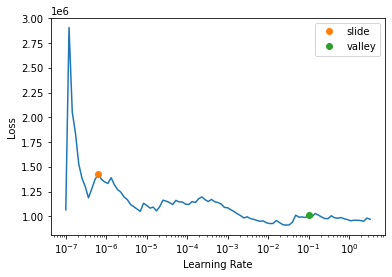

In [19]:
learn.lr_find(suggest_funcs=(slide, valley))

In [20]:
learn.fit(16, lr = 0.013176)

epoch,train_loss,valid_loss,accuracy,time


/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(device, non_blocking=non_blocking)
/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(device, non_blocking=non_blocking)
/Users/tompham/Library/Python/3.10/lib/python/site-packages/fastai/torch_core.py:286: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  if isinstance(o,Tensor): return o.to(dev

KeyboardInterrupt: 

In [ ]:
tst_dl = learn.dls.test_dl(df_test)

In [ ]:
preds, _ = learn.get_preds(dl = tst.dl)

In [ ]:
df_test[dep_var] = preds.int()
sub_df = df_test[['id', 'sales']]
sub_df.to_csv('sub.csv', index = False)

In [ ]:
!head sub.csv

## Creating an ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics = accuracy, layers = [50, 50, 10])
    with learn.no_bar(),
    learn.no_logging(): learn.fit(16, lr = 0.083176)
    return learn.get_preds(dl = tst_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
df_test[dep_var] = ens_preds.int()
sub_df = tst_df[['id', 'sales']]
sub_df.to_csv('ens_sub.csv', index = False)

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [ ]:
# Initialize the model
from sklearn.tree import DecisionTreeRegressor
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

In [ ]:
# Display the generated tree
from dtreeviz.trees import *
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
# Train the model with different parameters
m = DecisionTreeRegressor(min_samples_leaf = 100)
m.fit(xs, y)

Create function to check the model performance

In [ ]:
def r_msle(pred, y): return round(math.sqrt(((np.log(1 + pred) - np.log(1 +y))**2).mean()), 6)
def m_rmsle(m, xs, y): return r_msle(m.predict(xs), y)

In [ ]:
m_rmsle(m, xs, y)

In [ ]:
# Check the performance on the validation set
m_rmsle(m, valid_xs, valid_y)

In [ ]:
m.get_n_leaves()